In [1]:
# general tools
import sys
from glob import glob
# data tools
import time
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import model_utils as mu
import train_utils as tu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from importlib import reload
reload(mu)

<module 'model_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/model_utils.py'>

In [4]:
tf.image.total_variation

<function tensorflow.python.ops.image_ops_impl.total_variation(images, name=None)>

### Cycle GAN design

In [5]:
from model_utils import *

In [6]:
import tensorflow_addons as tfa

In [7]:
# def res_block(x_in, filters, scaling):

#     x = Conv2D(filters, 3, padding='same')(x_in)
#     x = Activation('relu')(x)
#     x = Conv2D(filters, 3, padding='same')(x)
#     x = Add()([x_in, x])
#     if scaling:
#         x = Lambda(lambda t: t * scaling)(x)
#     return x

In [8]:
def RES_Block(X_in, channel, kernel_size, activation, name):

    X = keras.layers.Conv2D(channel, kernel_size, padding='same', use_bias=False, 
                            kernel_initializer='he_normal', name=name+'_conv0')(X_in)
    X = keras.layers.BatchNormalization(axis=3, name=name+'_bn0')(X)
    if activation == 'relu':
        X = keras.layers.ReLU(name=name+'_relu0')(X)
    elif activation == 'leaky':
        X = keras.layers.LeakyReLU(name=name+'_leaky0')(X)
        
    X = keras.layers.Conv2D(channel, kernel_size, padding='same', use_bias=False, 
                            kernel_initializer='he_normal', name=name+'_conv1')(X)
    X = keras.layers.Add()([X_in, X])
    return X

In [9]:
def EDSR(channel, input_size, kernel_size=3, num=4, activation='relu'):
    '''
    EDSR (Enhanced Deep Residual Network)
    '''
    IN = keras.layers.Input(shape=input_size)
    X = keras.layers.Conv2D(channel, kernel_size, padding='same', use_bias=False, 
                            kernel_initializer='he_normal', name='edsr_conv0')(IN)
    X = keras.layers.BatchNormalization(axis=3, name='edsr_bn0')(X)
    if activation == 'relu':
        X = keras.layers.ReLU(name='edsr_relu0')(X)
    elif activation == 'leaky':
        X = keras.layers.LeakyReLU(name='edsr_leaky0')(X)
    X_res = X
    for i in range(num):
        X_res = RES_Block(X_res, channel, kernel_size, activation, name='res_block{}'.format(i))
        
    X_res = keras.layers.Conv2D(channel, kernel_size, padding='same', use_bias=False, 
                                kernel_initializer='he_normal', name='edsr_conv1')(X_res)
    X_res = keras.layers.BatchNormalization(axis=3, name='edsr_bn1')(X_res)
    if activation == 'relu':
        X_res = keras.layers.ReLU(name='edsr_relu1')(X_res)
    elif activation == 'leaky':
        X_res = keras.layers.LeakyReLU(name='edsr_leaky1')(X_res)
    X = keras.layers.Add()([X, X_res])

    X = keras.layers.Conv2D(channel, kernel_size, padding='same', use_bias=False, 
                            kernel_initializer='he_normal', name='edsr_conv2')(X)
    X = keras.layers.BatchNormalization(axis=3, name='edsr_bn2')(X)
    if activation == 'relu':
        X = keras.layers.ReLU(name='edsr_relu2')(X)
    elif activation == 'leaky':
        X = keras.layers.LeakyReLU(name='edsr_leaky2')(X)

    OUT = keras.layers.Conv2D(1, 1, activation=keras.activations.linear, padding='same', name='edsr_exit')(X)

    return keras.models.Model([IN], [OUT])

In [10]:
def flat_descriminator(N, input_size, activation='leaky'):
    '''
    CNN with stacked convolutional layers
    '''
    IN = keras.layers.Input(input_size, name='d_in')

    X = CONV_stack(IN, N, kernel_size=3, stack_num=3, activation=activation, name='d_conv1')

    X = keras.layers.GlobalAveragePooling2D(name='d_avepool')(X)
    FLAG = keras.layers.Dense(1, activation=keras.activations.sigmoid)(X) #, 

    return keras.models.Model(inputs=[IN], outputs=[FLAG])

In [11]:
def cycle_graph_clean(G1, D1, G2, input_shape):
    '''
    G1 --> D1 --> G2 --> loss
    '''

    ELEV_IN = keras.layers.Input(shape=(None, None, 1))
        
    G1.trainable = True
    G2.trainable = False
    D1.trainable = False
    
    # d loss branch
    # ERA LR --> G1 --> D1 --> (calculate D loss) adversarial loss
    GAN_IN = keras.layers.Input(shape=input_shape)
    G1_OUT = G1(GAN_IN)
    D1_OUT = D1(G1_OUT)
        
    # identity loss branch
    # clean LR --> G1 --> (compare with itself) identity loss BP
    ID_IN = keras.layers.Input(shape=input_shape)
    ID_OUT = G1(ID_IN)
    
    # forward cycle
    # ERA LR --> G1 --> G2 --> (compare with itself) cycle consistency loss
    G_OUT_forward = G2(G1_OUT)

    
    # backward cycle
    # clean LR --> G2 --> G1 --> (compare with itself) cycle consistency loss
    ID_IN_sub = keras.layers.Lambda(lambda x: x[:, :, :, 0][..., None])(ID_IN) # [..., None] for 4-dim tensor
    IN_OUT2 = G2(ID_IN_sub)
    IN_OUT2_concat = keras.layers.Concatenate()([IN_OUT2, ELEV_IN])
    G_OUT_backward = G1(IN_OUT2_concat)

    # define model graph
    cycle_GAN = keras.models.Model([GAN_IN, ID_IN, ELEV_IN], [D1_OUT, G1_OUT, ID_OUT, G_OUT_forward, G_OUT_backward])

    
    # define optimization algorithm configuration
    opt = keras.optimizers.Adam(lr=1e-4)
    # compile model with weighting of least squares loss and L1 loss
    cycle_GAN.compile(loss=[keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error,], 
                  loss_weights=[1, 1, 1, 1, 1], 
                  optimizer=opt)
    return cycle_GAN

In [12]:
def cycle_graph_reanalysis(G1, D1, G2, input_shape, elev_in=False):
    '''
    G1 --> D1 --> G2 --> loss
    '''

    ELEV_IN = keras.layers.Input(shape=(None, None, 1))
        
    G1.trainable = True
    G2.trainable = False
    D1.trainable = False
    
    # d loss branch
    # ERA LR --> G1 --> D1 --> (calculate D loss) adversarial loss
    GAN_IN = keras.layers.Input(shape=input_shape)
    G1_OUT = G1(GAN_IN)
    D1_OUT = D1(G1_OUT)
        
    # identity loss branch
    # clean LR --> G1 --> (compare with itself) identity loss BP
    ID_IN = keras.layers.Input(shape=input_shape)
    ID_OUT = G1(ID_IN)
    
    # forward cycle
    # ERA LR --> G1 --> G2 --> (compare with itself) cycle consistency loss
    G1_OUT_concat = keras.layers.Concatenate()([G1_OUT, ELEV_IN])
    G_OUT_forward = G2(G1_OUT_concat)
    
    # backward cycle
    # clean LR --> G2 --> G1 --> (compare with itself) cycle consistency loss
    IN_concat = keras.layers.Concatenate()([ID_IN, ELEV_IN])
    IN_OUT2 = G2(IN_concat)
    G_OUT_backward = G1(IN_OUT2)
    
    # define model graph
    cycle_GAN = keras.models.Model([GAN_IN, ID_IN, ELEV_IN], [D1_OUT, ID_OUT, G_OUT_forward, G_OUT_backward])

    
    # define optimization algorithm configuration
    opt = keras.optimizers.Adam(lr=1e-4)
    # compile model with weighting of least squares loss and L1 loss
    cycle_GAN.compile(loss=[keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error,
                            keras.losses.mean_squared_error], 
                  loss_weights=[1, 1, 1, 1], 
                  optimizer=opt)
    return cycle_GAN

In [13]:
# A: era/jra/fnl LR
# B: LR PRISM
opt_G = keras.optimizers.Adam(lr=1e-4)
G_A2B = EDSR(64, (None, None, 2), num=4, activation='leaky')
G_A2B.compile(loss=keras.losses.mean_squared_error, optimizer=opt_G)

G_B2A = EDSR(64, (None, None, 1), num=4, activation='leaky')
G_B2A.compile(loss=keras.losses.mean_squared_error, optimizer=opt_G)

opt_D = keras.optimizers.Adam(lr=1e-4)
D_A = flat_descriminator(64, (None, None, 1), activation='leaky')
D_A.compile(loss=keras.losses.mean_squared_error, optimizer=opt_D)
    
D_B = flat_descriminator(64, (None, None, 1), activation='leaky')
D_B.compile(loss=keras.losses.mean_squared_error, optimizer=opt_D)

In [15]:
cycle_GAN_AtoB = cycle_graph_clean(G_A2B, D_B, G_B2A, (None, None, 2))
cycle_GAN_BtoA = cycle_graph_reanalysis(G_B2A, D_A, G_A2B, (None, None, 1))

In [16]:
cycle_GAN_AtoB.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, None, None, 1 371649      input_4[0][0]                    
                                                                 input_5[0][0]                    
                                                                 concatenate[0][0]                
____________________________________________________________________________________________

### Training

In [13]:
from glob import glob
from random import shuffle
from scipy.ndimage import gaussian_filter

In [14]:
file_path = BATCH_dir
# paired samples (LR PRISM training domain)
train_paired_64 = glob(file_path+'TMEAN_BATCH_64_TORI_*.npy')
train_paired_96 = glob(file_path+'TMEAN_BATCH_96_TORI_*.npy')
valid_paired_64 = glob(file_path+'TMEAN_BATCH_64_VSUB_*.npy')
valid_paired_96 = glob(file_path+'TMEAN_BATCH_96_VSUB_*.npy')

# unpaired samples (LR reanalysis everywhere)
train_era_64 = glob(file_path+'TMEAN_BATCH_64_TERA_*.npy')
train_era_96 = glob(file_path+'TMEAN_BATCH_96_TERA_*.npy')
train_jra_64 = glob(file_path+'TMEAN_BATCH_64_TJRA_*.npy')
train_jra_96 = glob(file_path+'TMEAN_BATCH_96_TJRA_*.npy')
# valid_era_64 = glob(file_path+'TMEAN_BATCH_64_VERA_*.npy')
# valid_era_96 = glob(file_path+'TMEAN_BATCH_96_VERA_*.npy')
# valid_jra_64 = glob(file_path+'TMEAN_BATCH_64_VJRA_*.npy')
# valid_jra_96 = glob(file_path+'TMEAN_BATCH_96_VJRA_*.npy')

input_flag_paired = [False, True, False, False, False, True]
output_flag_paired = [False, True, False, False, False, False]
input_flag_era = [True, True, False]

Text(0.5, 1.0, 'LR PRISM nearby (naive 0.25 deg)')

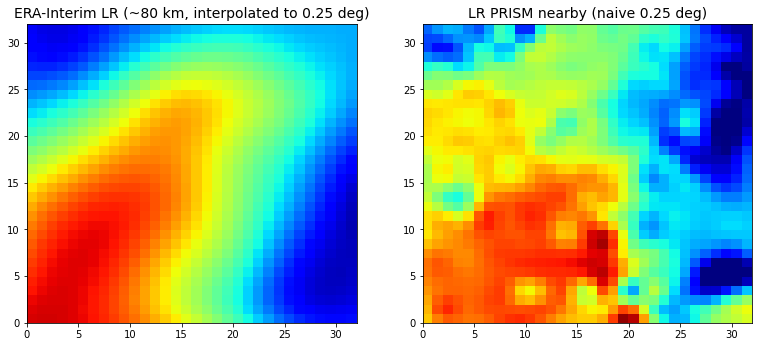

In [15]:
temp_data_A = np.copy(np.load(train_era_96[0], allow_pickle=True)[()]['batch'][..., input_flag_era])
temp_data_B = np.copy(np.load(train_paired_96[0], allow_pickle=True)[()]['batch'][..., input_flag_paired])

gap = 3

fig, AX = plt.subplots(1, 2, figsize=(13, 5.5))
AX[0].pcolormesh(temp_data_A[3, ::gap, ::gap, 0], vmin=-2, vmax=2, cmap=plt.cm.jet)
AX[1].pcolormesh(temp_data_B[1, ::gap, ::gap, 0], vmin=-2, vmax=2, cmap=plt.cm.jet)
#AX[2].pcolormesh(temp_data_B[1, ..., 1], vmin=-2, vmax=2, cmap=plt.cm.jet)
AX[0].set_title('ERA-Interim LR (~80 km, interpolated to 0.25 deg)', fontsize=14)
AX[1].set_title('LR PRISM nearby (naive 0.25 deg)', fontsize=14)
#AX[2].set_title('LR ELEV', fontsize=14)

In [24]:
model = keras.models.load_model('/glade/work/ksha/data/Keras/BACKUP/CB-GAN_TMEAN_LR.hdf')

In [25]:
train_size = batch_size
filter_std = 8 + np.random.uniform(low=-2, high=2, size=(train_size))
temp_ori = np.copy(temp_data_B)

for k in range(train_size):
    zero_mask = np.copy(temp_data_B[k, ..., 0]==0)
    temp_blur = gaussian_filter(temp_data_B[k, ..., 0], filter_std[k])
    temp_blur[zero_mask]=np.nan
    temp_data_B[k, ..., 0] = du.fillzero(du.norm_std(temp_blur))




# blur_B = np.copy(temp_data_B)
# for i in range(batch_size):
#     blur_B[i, ..., 0] = du.norm_std(gaussian_filter(blur_B[i, ..., 0], 10))
# ind = 1

dblur_B = model.predict(temp_data_B)
# blur_B[..., 0] = dblur_B[..., 0]
# dblur_B = model.predict(blur_B)
# blur_B[..., 0] = dblur_B[..., 0]
# dblur_B = model.predict(blur_B)
#dblur_B2 = model.predict(blur_B)

Text(0.5, 1.0, 'Original LR PRISM')

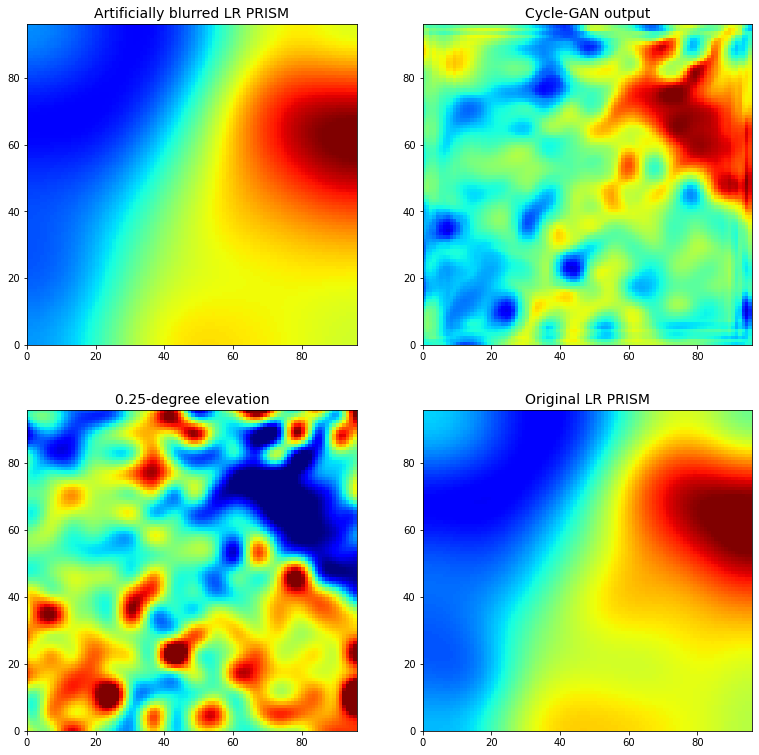

In [26]:
ind = 9
gap = 1
fig, AX = plt.subplots(2, 2, figsize=(13, 13))
AX[0][0].pcolormesh(temp_data_B[ind, ::gap, ::gap, 0], vmin=-2, vmax=2, cmap=plt.cm.jet)
AX[1][0].pcolormesh(temp_data_B[ind, ::gap, ::gap, 1], vmin=-2, vmax=2, cmap=plt.cm.jet)

AX[0][1].pcolormesh(dblur_B[ind, ::gap, ::gap, 0], vmin=-2, vmax=2, cmap=plt.cm.jet)
AX[1][1].pcolormesh(temp_ori[ind, ::gap, ::gap, 0], vmin=-2, vmax=2, cmap=plt.cm.jet)

AX[0][0].set_title('Artificially blurred LR PRISM', fontsize=14)
AX[1][0].set_title('0.25-degree elevation', fontsize=14)
AX[0][1].set_title('Cycle-GAN output', fontsize=14)
AX[1][1].set_title('Original LR PRISM', fontsize=14)

In [27]:
hist_path = temp_dir+'LOSS_CGAN_TMEAN_LR.npy'
temp_data1 = np.load(hist_path, allow_pickle=True)[()]

hist_path = temp_dir+'LOSS_CB-GAN_TMEAN_LR.npy'
temp_data2 = np.load(hist_path, allow_pickle=True)[()]

hist_path = temp_dir+'LOSS_Cycle-GAN_TMEAN_LR.npy'
temp_data3 = np.load(hist_path, allow_pickle=True)[()]

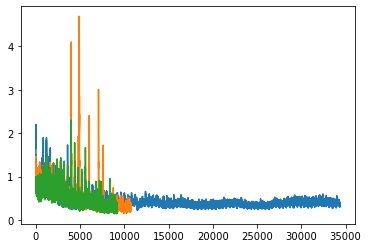

In [28]:
plt.plot(temp_data1['GAN_LOSS_B'][20:, -2])

plt.plot(temp_data3['GAN_LOSS_B'][20:, -2])
plt.plot(temp_data2['GAN_LOSS_B'][20:, -2])

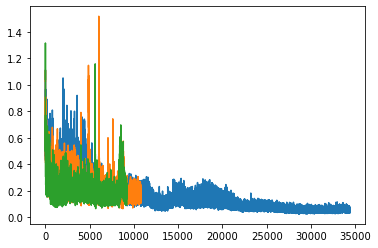

In [29]:
plt.plot(temp_data1['GAN_LOSS_A'][20:, -2])

plt.plot(temp_data3['GAN_LOSS_A'][20:, -2])
plt.plot(temp_data2['GAN_LOSS_A'][20:, -2])

In [231]:
# test = model.predict(temp_data_A[..., input_flag_era])
# fig, AX = plt.subplots(1, 2, figsize=(12, 5))
# AX[0].pcolormesh(test[3, ..., 0], vmin=-2, vmax=2, cmap=plt.cm.jet)
# AX[1].pcolormesh(temp_data_A[..., input_flag_era][3, ..., 1], vmin=-2, vmax=2, cmap=plt.cm.jet)

In [20]:
print('era-interim training batches: {}'.format(len(train_era_64)+len(train_era_96)))
print('jra-55 training batches: {}'.format(len(train_jra_64)+len(train_jra_96)))

print('prism training batches: {}'.format(len(train_paired_64)+len(train_paired_96)))
print('prism validation batches: {}'.format(len(valid_paired_64)+len(valid_paired_96)))

era-interim training batches: 2943
jra-55 training batches: 2942
prism training batches: 2825
prism validation batches: 155


In [21]:
# data generators for valid set
labels = ['batch', 'batch']
gen_valid = tu.grid_grid_gen(valid_paired_64+valid_paired_96, labels, input_flag_paired, output_flag_paired)

In [22]:
epochs = 150

steps_per = 200
steps_half = 100

train_size = 64
train_half = 32

L_train = steps_per+steps_per

min_del = 0
max_tol = 4 # early stopping with patience

In [23]:
key = 'CGAN'
model_name = '{}_TMEAN_LR'.format(key)
model_path = temp_dir+model_name+'.hdf'
hist_path = temp_dir+'LOSS_{}_TMEAN_LR.npy'.format(key)
# save the forward cycle G only
#cycle_GAN_AtoB.layers[2].save(model_path)

In [24]:
tol = 0
record = 999
GAN_LOSS_A = np.zeros([int(epochs*L_train), 5])*np.nan
GAN_LOSS_B = np.zeros([int(epochs*L_train), 6])*np.nan
D_LOSS_A = np.zeros([int(epochs*L_train)])*np.nan
D_LOSS_B = np.zeros([int(epochs*L_train)])*np.nan
V_LOSS = np.zeros([epochs])*np.nan

for i in range(epochs):
    print('epoch = {}'.format(i))
    start_time = time.time()
    # ----- shuffle ----- #
    shuffle(train_paired_64)
    shuffle(train_paired_96)
    shuffle(train_era_64)
    shuffle(train_era_96)
    shuffle(train_jra_64)
    shuffle(train_jra_96)
    # ------------------- #
    
    temp_paired = train_paired_64[:steps_per] + train_paired_96[:steps_per]
    temp_reanalysis = train_era_64[:steps_half] + \
                      train_jra_64[:steps_half] + \
                      train_era_96[:steps_half] + \
                      train_jra_96[:steps_half]
    #shuffle(temp_paired)
    #shuffle(temp_reanalysis)
    
    for j in range(L_train):
        
        # ----- File pipeline ----- #
        # (samples, size, size, channels), channels = (LR TMEAN, LR ELEV)
        inds = du.shuffle_ind(batch_size)[:train_size]
        X_paired = np.load(temp_paired[j], allow_pickle=True)[()]['batch'][inds, ...]
        X_reanalysis = np.load(temp_reanalysis[j], allow_pickle=True)[()]['batch'][inds, ...]
        
        IN_paired = X_paired[..., input_flag_paired]
        IN_paired_sub = IN_paired[..., 0][..., None]
        IN_paired_elev = IN_paired[..., 1][..., None]
        
        OUT_paired = X_paired[..., output_flag_paired]
        IN_reanalysis = X_reanalysis[..., input_flag_era]
        IN_reanalysis_sub = IN_reanalysis[..., 0][..., None]
        IN_reanalysis_elev = IN_reanalysis[..., 1][..., None]
        
 
        G_A2B.train_on_batch([IN_reanalysis], [-1*IN_reanalysis_elev]);
            
        # ----- train AtoB generators ----- #
        dummy_good = np.ones(train_size)*0.9 + np.random.uniform(-0.02, 0.02, train_size)
        # the order of loss: d loss, identity loss, cycle loss
        gan_loss_b = cycle_GAN_AtoB.train_on_batch([IN_reanalysis, IN_paired, IN_reanalysis_elev], 
                                                   [dummy_good, -1*IN_reanalysis_elev, IN_paired_sub, 
                                                    IN_reanalysis_sub, IN_paired_sub])
        # ----- train D_B ----- #
        # soft labels
        dummy_bad = np.ones(train_size)*0.1 + np.random.uniform(-0.02, 0.02, train_size)
        dummy_good = np.ones(train_size)*0.9 + np.random.uniform(-0.02, 0.02, train_size)
        
        fake_B_paired = G_A2B.predict([IN_paired])
        fake_B_reanalysis = G_A2B.predict([IN_reanalysis])
        real_B = OUT_paired[:train_size, ...]
        d_b_loss1 = D_B.train_on_batch(fake_B_paired[:train_half], dummy_bad[:train_half])
        d_b_loss1 += D_B.train_on_batch(fake_B_reanalysis[:train_half], dummy_bad[:train_half])
        d_b_loss2 = D_B.train_on_batch(real_B, dummy_good)
        
        # ----- train BtoA generators ----- #
        dummy_good = np.ones(train_size)*0.9 + np.random.uniform(-0.02, 0.02, train_size)
        gan_loss_a = cycle_GAN_BtoA.train_on_batch([IN_paired_sub, IN_reanalysis_sub, IN_paired_elev],
                                                   [dummy_good, IN_reanalysis_sub, IN_paired_sub, IN_reanalysis_sub])
        
        # ----- train D_A ----- #
        fake_A = G_B2A.predict([IN_paired_sub])[:train_size, ...]
        real_A = IN_reanalysis_sub[:train_size, ...]
        d_a_loss1 = D_A.train_on_batch(fake_A, dummy_bad)
        d_a_loss2 = D_A.train_on_batch(real_A, dummy_good)
        
        # ----- Backup training loss ----- #
        D_LOSS_B[i*L_train+j] = 0.5*(d_b_loss1 + d_b_loss2)
        D_LOSS_A[i*L_train+j] = 0.5*(d_a_loss1 + d_a_loss2)
        GAN_LOSS_B[i*L_train+j, :] = gan_loss_b
        GAN_LOSS_A[i*L_train+j, :] = gan_loss_a
        # -------------------------------- #
        if j%50 == 0:
            print('\t{} step loss = {}'.format(j, gan_loss_b))
            
    record_temp = G_A2B.evaluate_generator(gen_valid, verbose=1)
    # Backup validation loss
    V_LOSS[i] = record_temp
    # Overwrite loss info
    LOSS = {'GAN_LOSS_A':GAN_LOSS_A,
            'GAN_LOSS_B':GAN_LOSS_B,
            'D_LOSS_A': D_LOSS_A,
            'D_LOSS_B': D_LOSS_B,
            'V_LOSS':V_LOSS}
    np.save(hist_path, LOSS)

    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        G_A2B.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

epoch = 0
	0 step loss = [82.13873, 0.406995, 0.5736277, 0.79237336, 78.747955, 1.6177831]
	50 step loss = [3.3992605, 0.24256223, 0.0792696, 0.5524334, 0.80751324, 1.7174821]
	100 step loss = [3.009331, 0.26282084, 0.03234658, 0.48517644, 0.72736645, 1.5016207]
	150 step loss = [2.8215232, 0.2636916, 0.02289214, 0.6488272, 0.69137233, 1.1947398]
	200 step loss = [2.6484761, 0.22853354, 0.022764646, 0.66936576, 0.7788109, 0.9490013]
	250 step loss = [2.9327497, 0.26348937, 0.02609124, 1.057271, 0.7497678, 0.8361305]
	300 step loss = [2.573072, 0.29400316, 0.048845954, 0.61099863, 0.7399763, 0.879248]
	350 step loss = [2.2851841, 0.25342584, 0.039955664, 0.9351345, 0.6648645, 0.39180365]
Instructions for updating:
Please use Model.evaluate, which supports generators.
155/155 [==============================] - 31s 201ms/step - loss: 0.6340
Validation loss improved from 999 to 0.63402411457031
tol: 0
save to: /glade/work/ksha/data/Keras/BACKUP/CGAN_TMEAN_LR.hdf
Instructions for updating:


KeyboardInterrupt: 

In [ ]:
cycle_GAN_BtoA.layers

In [25]:
test = cycle_GAN_AtoB.layers[2].predict(temp_data_A[..., input_flag_era])

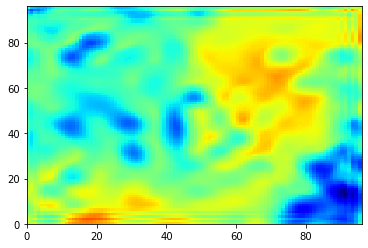

In [32]:
plt.pcolormesh(test[12, ..., 0], vmin=-3, vmax=3, cmap=plt.cm.jet)

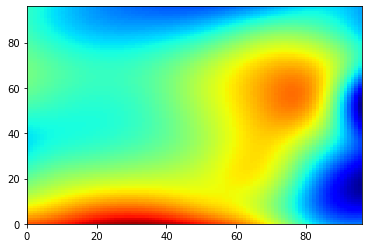

In [34]:
plt.pcolormesh(temp_data_A[..., input_flag_era][12, ..., 0], vmin=-3, vmax=3, cmap=plt.cm.jet)

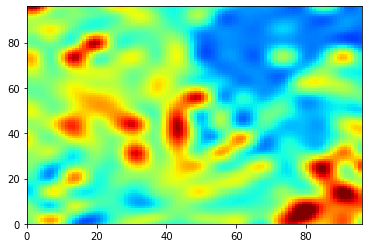

In [33]:
plt.pcolormesh(temp_data_A[..., input_flag_era][12, ..., 1], vmin=-3, vmax=3, cmap=plt.cm.jet)